### Taxonomic Profiling 
- Taxonomic profiling of reads
- Kraken..ignore sylph for now 

#### Sylph
https://github.com/bluenote-1577/sylph
- average nucleic identity (ANI) querying or taxonomic profiling

In [2]:
#activate unity interactive job..need high memory for installation
salloc -p cpu --mem 150G

SyntaxError: invalid syntax (779215978.py, line 2)

In [ ]:
%conda init --all

In [ ]:
#module load miniconda/22.11.1-1
#conda create -n taxa
%conda activate taxa

In [ ]:
#install sylph package
conda install -c bioconda sylph
#if above doesnt work do: 
conda install -c bioconda -c conda-forge sylph

In [ ]:
#set parameters
SAMPLENAME=mcav
CONTIGPATH=/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/results/mcav_assembly3
CONTIGFILE=mcav.contigs-fixed.fa

In [ ]:
#sketch paired-end reads
sylph sketch -1 ./trimmed/*_R1_001_val_1.fq -2 ./trimmed/*_R2_001_val_2.fq -d "$SAMPLENAME"_sketches -t 50 
#decrease -c (default =200)...

In [ ]:
#create database if contigs are all in one fasta file
sylph sketch $CONTIGPATH/$CONTIGFILE -i -o ./working/"$SAMPLENAME"_contig_database

In [ ]:
# query for ANI 
sylph query "$SAMPLENAME"_sketches/*.sylsp ./working/"$SAMPLENAME"_contig_database.syldb
#output is statistics for each genome against our reads
#redirect output??
#Thus sylph query is not a profiler. It does not tell you the abundance of the genomes in your sample, just how similar your query genome is to the genomes within the sample.

In [ ]:
#Import taxa database: https://github.com/bluenote-1577/sylph/wiki/Pre%E2%80%90built-databases
wget https://storage.googleapis.com/sylph-stuff/v0.3-c200-gtdb-r214.syldb -O gtdb_database.syldb

In [ ]:
#move database into folder called gtdb_genomes_reps_r214
mkdir working/gtdb_genomes_reps_r214
mv gtdb_database.syldb working/gtdb_genomes_reps_r214/gtdb_database.syldb

#set path to GTDB
DB=working/gtdb_genomes_reps_r214/gtdb_database.syldb
#set input & output path
INDIR=mcav_sketches
OUTDIR=results/taxonomy

In [ ]:
#maps samples against contig database???
#read more: https://github.com/bluenote-1577/sylph/wiki/sylph-cookbook#creating-a-database-of-fasta-files
sylph profile "$SAMPLENAME"_sketches/*.sylsp ./working/"$SAMPLENAME"_contig_database.syldb -t 50 -o ./results/"$SAMPLENAME"_sylph_profile.tsv

In [ ]:
#map reads against GTDB 
sylph profile $INDIR/*_MCAV_R1_001_val_1.fq.paired.sylsp "$DB" -t 10 -o $OUTDIR/sylph_GTDB.tsv

In [ ]:
#get taxonomic profile 
#clone repo (in "working" dir)
git clone https://github.com/bluenote-1577/sylph
python working/sylph/scripts/sylph_to_taxprof.py -s $OUTDIR/sylph_GTDB.tsv -m  working/sylph/scripts/gtdb_r214_metadata.tsv.gz -o $OUTDIR/prefix_.tsv

#results: only 6 samples have hits on the reference genomes database

In [ ]:
#convert to tsv

# Loop over all files 
for input_file in prefix_*_R1_001_val_1.fq.sylphmpa; do
    # Extract the unique identifier from the file name
    unique_identifier=$(echo "$input_file" | sed 's/^prefix_\(.*\)_R1_001_val_1\.fq\.sylphmpa$/\1/')

    # Generate the output TSV file name
    output_file="${unique_identifier}.tsv"

    # Process the input file and save the result to the output file
    awk -F'\t' '{for (i=1; i<=NF; i++) printf "%s%s", $i, (i<NF ? "\t" : "\n")}' "$input_file" > "$output_file"

    echo "Processed $input_file and saved as $output_file"
done


In [ ]:
#repeating with OceanDNA database
wget https://storage.googleapis.com/sylph-stuff/OceanDNA-c200-v0.3.syldb
mv OceanDNA-c200-v0.3.syldb working/gtdb_genomes_reps_r214/OceanDNA-c200-v0.3.syldb
oceanDB=working/gtdb_genomes_reps_r214/OceanDNA-c200-v0.3.syldb

sylph profile $INDIR/*_MCAV_R1_001_val_1.fq.paired.sylsp "$oceanDB" -t 10 -o $OUTDIR/sylph_ocean.tsv

#### Kraken
- https://ccb.jhu.edu/software/kraken/MANUAL.html

https://bioinformaticsworkbook.org/dataAnalysis/Metagenomics/Kraken.html#gsc.tab=0

https://bioinformatics.stackexchange.com/questions/20589/kraken2-standard-database-failing-to-build-unexpected-ftp-path?rq=1

https://github.com/DerrickWood/kraken2/issues/292

##### Install gorg tropics database (marine metagenomes)
- https://www.sciencedirect.com/science/article/pii/S0092867419312735
- https://github.com/BigelowLab/gorg-classifier?tab=readme-ov-file
- https://osf.io/pcwj9/files/osfstorage

1. sign up for osf account 
2. ssh into unity 


In [ ]:
pip install osfclient
# Create a directory for the GORG-Tropics database
mkdir -p ~/gorg-tropics-db
cd ~/gorg-tropics-db

# Initialize the osfclient
osf init
# You will be prompted to enter ur username (OSF email) & project URL
# Use the URL: https://osf.io/pcwj9/

# List files in the OSF project to get the correct paths
osf list
# you'll be prompted to put in your password 

# Download the files (sadly have to do them individually or create bash script)
osf fetch 
osfstorage/gorg-tropics/classifier-dbs/GORG_v1_NCBI.fmi
osfstorage/gorg-tropics/classifier-dbs/GORG_v1_CREST.fmi
osfstorage/gorg-tropics/classifier-dbs/taxonomy/NCBI/nodes.dmp
osfstorage/gorg-tropics/classifier-dbs/taxonomy/NCBI/names.dmp
#osfstorage/gorg-tropics/classifier-dbs/taxonomy/CREST/names.dmp
#osfstorage/gorg-tropics/classifier-dbs/taxonomy/CREST/nodes.dmp
# just downloaded ncbi 
osfstorage/gorg-tropics/classifier-dbs/GORG_v1.tsv.gz
osfstorage/gorg-tropics/classifier-dbs/GORG_v1.fasta.gz
#osfstorage/gorg-tropics/classifier-dbs/GORG_v1_CREST.faa.gz
# don't think this one is needed 
osfstorage/gorg-tropics/classifier-dbs/GORG_v1_NCBI.faa.gz

# unzip
gunzip *.gz

##### Kraken setup/scripts 

In [ ]:
module load miniconda/22.11.1-1
module load kraken2/2.1.2

In [ ]:
# build 16S db
# download SILVA database
wget -c url https://genome-idx.s3.amazonaws.com/kraken/16S_Silva132_20200326.tgz
# unzip 
tar -xvzf //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_Silva132_20200326.tgz
DBNAME=//project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db

In [ ]:
#build standard db https://benlangmead.github.io/aws-indexes/k2
DBNAME=/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/standard
kraken2-build --standard --threads 24 --db $DBNAME
# slurm id 22720772

# errors: ftp error
find /home/brooke_sienkiewicz_student_uml_edu -type f -name "rsync_from_ncbi.pl"
# fix executables: https://github.com/DerrickWood/kraken2/issues/226

#Error: "/all/GCF/030/643/725/GCF_030643725.1_ASM3064372v1/GCF_030643725.1_ASM3064372v1_genomic.fna.gz" (in genomes) failed: No such file or directory (2)
# fix: https://www.biostars.org/p/295221/

# original in rsync_from_ncbi.pl: 
open MANIFEST, ">", "manifest.txt"
  or die "$PROG: can't write manifest: $!\n";
print MANIFEST "$_\n" for keys %manifest;
close MANIFEST;

print STDERR "Step 1/2: Performing rsync file transfer of requested files\n";
system("rsync --no-motd --files-from=manifest.txt rsync://ftp.ncbi.nlm.nih.gov/genomes/ .") == 0
  or die "$PROG: rsync error, exiting: $?\n";
print STDERR "Rsync file transfer complete.\n";
print STDERR "Step 2/2: Assigning taxonomic IDs to sequences\n";
my $output_file = $is_protein ? "library.faa" : "library.fna";
open OUT, ">", $output_file
  or die "$PROG: can't write $output_file: $!\n";
    
# mod:
open MANIFEST, ">", "manifest.txt"
  or die "$PROG: can't write manifest: $!\n";
print MANIFEST "$_\n" for keys %manifest;
close MANIFEST;

print STDERR "Step 1/2: Performing wget file transfer of requested files\n";
if (system("wget -nc -nH -x --cut-dirs=1 -i manifest.txt -B ftp://ftp.ncbi.nlm.nih.gov/genomes/") != 0) {
  die "$PROG: wget error, exiting: $?\n";
}
print STDERR "Wget file transfer complete.\n";
print STDERR "Step 2/2: Assigning taxonomic IDs to sequences\n";
my $output_file = $is_protein ? "library.faa" : "library.fna";
open OUT, ">", $output_file
  or die "$PROG: can't write $output_file: $!\n";

# redo build 
DBNAME=/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/standard
kraken2-build --standard --threads 24 --db $DBNAME --use-ftp

In [ ]:
# just downloading already built db? https://benlangmead.github.io/aws-indexes/k2 (standard)

In [ ]:
#!/bin/bash
#SBATCH -c 24  # Number of Cores per Task
#SBATCH --mem=180G  # Requested Memory
#SBATCH -p cpu  # Partition
#SBATCH -t 24:00:00  # Job time limit
#SBATCH --mail-type=ALL
#SBATCH -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/slurm-kraken-%j.out  # %j = job ID

module load miniconda/22.11.1-1
conda activate kraken


# set variables
DBNAME=//project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/standard
READSPATH=/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/host_removed
OUTDIR=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb

#run from brooke dir 
# classify each set of paired end reads against silva taxonomic database
while IFS= read -r SAMPLEID; do
kraken2 --db $DBNAME --threads 22 --report $OUTDIR/${SAMPLEID}.kreport2 --report-zero-counts --paired $READSPATH/"${SAMPLEID}"_host_removed_R1.fastq $READSPATH/"${SAMPLEID}"_host_removed_R2.fastq > $OUTDIR/${SAMPLEID}.kraken2
done < mcav/healthy_2019_mcav/"healthy_2019_MCAV_sampleids"
#add 'report-zero-counts' so that all reports have same taxa so they can be merged

#bash script: brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb
#JOB ID: 22766490
# !

##### Kracken classification results 

###### 16S - silva db 

In [ ]:
Loading database information... done.
78898318 sequences (23502.15 Mbp) processed in 468.300s (10108.7 Kseq/m, 3011.17 Mbp/m).
  259180 sequences classified (0.33%)
  78639138 sequences unclassified (99.67%)
Loading database information... done.
2427227 sequences (702.29 Mbp) processed in 13.503s (10785.6 Kseq/m, 3120.68 Mbp/m).
  46494 sequences classified (1.92%)
  2380733 sequences unclassified (98.08%)
Loading database information... done.
8436904 sequences (2511.26 Mbp) processed in 51.082s (9909.9 Kseq/m, 2949.69 Mbp/m).
  34983 sequences classified (0.41%)
  8401921 sequences unclassified (99.59%)
Loading database information... done.
3891938 sequences (1148.95 Mbp) processed in 22.887s (10203.1 Kseq/m, 3012.08 Mbp/m).
  20334 sequences classified (0.52%)
  3871604 sequences unclassified (99.48%)
Loading database information... done.
4166616 sequences (1241.14 Mbp) processed in 25.214s (9914.9 Kseq/m, 2953.45 Mbp/m).
  21806 sequences classified (0.52%)
  4144810 sequences unclassified (99.48%)
Loading database information... done.
3722331 sequences (1102.37 Mbp) processed in 22.363s (9986.9 Kseq/m, 2957.63 Mbp/m).
  23332 sequences classified (0.63%)
  3698999 sequences unclassified (99.37%)
Loading database information... done.
6548146 sequences (1942.36 Mbp) processed in 40.071s (9804.7 Kseq/m, 2908.35 Mbp/m).
  29558 sequences classified (0.45%)
  6518588 sequences unclassified (99.55%)
Loading database information... done.
2321387 sequences (688.72 Mbp) processed in 14.950s (9316.7 Kseq/m, 2764.11 Mbp/m).
  9776 sequences classified (0.42%)
  2311611 sequences unclassified (99.58%)
Loading database information... done.
7533935 sequences (2234.54 Mbp) processed in 45.334s (9971.3 Kseq/m, 2957.46 Mbp/m).
  26914 sequences classified (0.36%)
  7507021 sequences unclassified (99.64%)
Loading database information... done.
1094028 sequences (250.91 Mbp) processed in 4.775s (13748.1 Kseq/m, 3153.08 Mbp/m).
  3150 sequences classified (0.29%)
  1090878 sequences unclassified (99.71%)
Loading database information... done.
3141837 sequences (813.97 Mbp) processed in 16.253s (11598.7 Kseq/m, 3004.90 Mbp/m).
  7691 sequences classified (0.24%)
  3134146 sequences unclassified (99.76%)
Loading database information... done.
9068181 sequences (2531.39 Mbp) processed in 52.433s (10376.8 Kseq/m, 2896.69 Mbp/m).
  23308 sequences classified (0.26%)
  9044873 sequences unclassified (99.74%)
Loading database information... done.
1861982 sequences (461.12 Mbp) processed in 9.232s (12101.5 Kseq/m, 2996.93 Mbp/m).
  6449 sequences classified (0.35%)
  1855533 sequences unclassified (99.65%)

###### RefSeq db (everything)

In [ ]:
Loading miniconda version 22.11.1-1
Loading database information... done.
78898318 sequences (23502.15 Mbp) processed in 1108.886s (4269.1 Kseq/m, 1271.66 Mbp/m).
  4684493 sequences classified (5.94%)
  74213825 sequences unclassified (94.06%)
Loading database information... done.
2427227 sequences (702.29 Mbp) processed in 31.707s (4593.1 Kseq/m, 1328.94 Mbp/m).
  201723 sequences classified (8.31%)
  2225504 sequences unclassified (91.69%)
Loading database information... done.
8436904 sequences (2511.26 Mbp) processed in 117.590s (4304.9 Kseq/m, 1281.36 Mbp/m).
  742011 sequences classified (8.79%)
  7694893 sequences unclassified (91.21%)
Loading database information... done.
3891938 sequences (1148.95 Mbp) processed in 54.581s (4278.3 Kseq/m, 1263.02 Mbp/m).
  375924 sequences classified (9.66%)
  3516014 sequences unclassified (90.34%)
Loading database information... done.
4166616 sequences (1241.14 Mbp) processed in 58.175s (4297.3 Kseq/m, 1280.08 Mbp/m).
  388119 sequences classified (9.31%)
  3778497 sequences unclassified (90.69%)
Loading database information... done.
3722331 sequences (1102.37 Mbp) processed in 53.793s (4151.8 Kseq/m, 1229.56 Mbp/m).
  298375 sequences classified (8.02%)
  3423956 sequences unclassified (91.98%)
Loading database information... done.
6548146 sequences (1942.36 Mbp) processed in 117.470s (3344.6 Kseq/m, 992.10 Mbp/m).
  599273 sequences classified (9.15%)
  5948873 sequences unclassified (90.85%)
Loading database information... done.
2321387 sequences (688.72 Mbp) processed in 31.713s (4392.0 Kseq/m, 1303.04 Mbp/m).
  178973 sequences classified (7.71%)
  2142414 sequences unclassified (92.29%)
Loading database information... done.
7533935 sequences (2234.54 Mbp) processed in 106.531s (4243.2 Kseq/m, 1258.52 Mbp/m).
  643011 sequences classified (8.53%)
  6890924 sequences unclassified (91.47%)
Loading database information... done.
1094028 sequences (250.91 Mbp) processed in 11.632s (5643.1 Kseq/m, 1294.21 Mbp/m).
  86497 sequences classified (7.91%)
  1007531 sequences unclassified (92.09%)
Loading database information... done.
3141837 sequences (813.97 Mbp) processed in 38.400s (4909.1 Kseq/m, 1271.82 Mbp/m).
  217710 sequences classified (6.93%)
  2924127 sequences unclassified (93.07%)
Loading database information... done.
9068181 sequences (2531.39 Mbp) processed in 134.838s (4035.2 Kseq/m, 1126.42 Mbp/m).
  817753 sequences classified (9.02%)
  8250428 sequences unclassified (90.98%)
Loading database information... done.
1861982 sequences (461.12 Mbp) processed in 21.548s (5184.8 Kseq/m, 1284.00 Mbp/m).
  384507 sequences classified (20.65%)
  1477475 sequences unclassified (79.35%)

###### diseased mcav - kraken and bracken 

In [ ]:
## very low # of counts when host and symbiont are removed so just running kraken on host removed short reads..

In [ ]:
#!/bin/bash
#SBATCH -c 24  # Number of Cores per Task
#SBATCH --mem=180G  # Requested Memory
#SBATCH -p cpu  # Partition
#SBATCH -t 24:00:00  # Job time limit
#SBATCH --mail-type=ALL
#SBATCH -o /work/pi_sarah_gignouxwolfsohn_uml_edu/brooke/slurm-kraken-%j.out  # %j = job ID

# run kraken
module load miniconda/22.11.1-1
conda activate kraken

# Check if the environment was activated and print a confirmation message
if [ "$CONDA_DEFAULT_ENV" == "kraken" ]; then
    echo "Conda environment 'kraken' activated successfully."
else
    echo "Failed to activate Conda environment 'kraken'."
fi

# set variables
DBNAME=//project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/standard
READSPATH=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/assembly/host_removed
OUTDIR=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb
SAMPLELIST_PATH=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav
THREADS=20
KMER_LEN=35 #(default)
READ_LEN=150

#run from brooke dir 
# classify each set of paired end reads against taxonomic database
while IFS= read -r SAMPLEID; do
    echo "Processing sample: $SAMPLEID"
    kraken2 --db $DBNAME --threads $THREADS --report $OUTDIR/${SAMPLEID}.kreport2 --report-zero-counts --paired $READSPATH/"${SAMPLEID}"_host_removed_R1.fastq $READSPATH/"${SAMPLEID}"_host_removed_R2.fastq > $OUTDIR/${SAMPLEID}.kraken2
    if [ $? -eq 0 ]; then
        echo "Kraken2 classification completed for $SAMPLEID"
    else
        echo "Error in Kraken2 classification for $SAMPLEID"
    fi
done < $SAMPLELIST_PATH/diseased_MCAV
# run bracken

# navigate to Bracken dir because can't figure out how to set up symlink 
cd //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken
# Generate bracken database - just do once
#bracken-build -d ${DBNAME} -t ${THREADS} -k ${KMER_LEN} -l ${READ_LEN} 
# only need to do once

# Abundance Estimation
FILEPATH=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb
LEVEL="S"


while IFS= read -r line; do
    # Execute bracken command for each file
    bracken -d "$DBNAME" -i $FILEPATH/"$line".kreport2 -o "$FILEPATH/${line%.kreport2}_$LEVEL.bracken" -r "$READ_LEN" -l "$LEVEL"
done < $SAMPLELIST_PATH/diseased_MCAV

#${SAMPLE}.kreport - the kraken report generated for a given dataset
#{BRACKEN_OUTPUT_FILE}.bracken - the desired name of the output file to be generated by the code
#The following optional parameters may be specified:
    #${LEVEL} - Default = 'S'. This specifies that abundance estimation will calculate estimated reads for each species. Other possible options are K (kingdom level), P (phylum), C (class), O (order), F (family), and G (genus).
    #${THRESHOLD} - Default = 10. For species classification, any species with <= 10 (or otherwise specified) reads will not receive any additional reads from higher taxonomy levels when distributing reads for abundance estimation. 
    #If another classification level is specified, thresholding will occur at that level.

#bash script: kraken 
#JOB ID: 23070592

###### run kraken on just host_removed margin mcav and healthy 2022

In [ ]:
#!/bin/bash
#SBATCH -c 24  # Number of Cores per Task
#SBATCH --mem=180G  # Requested Memory
#SBATCH -p cpu  # Partition
#SBATCH -t 24:00:00  # Job time limit
#SBATCH --mail-type=ALL
#SBATCH -o /work/pi_sarah_gignouxwolfsohn_uml_edu/brooke/slurm-assemblytax-margin-%j.out  # %j = job ID

cd /project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav
module load miniconda/22.11.1-1

conda activate kraken
# all parameters
THREADS=20
KMER_LEN=35 #(default)
READ_LEN=150
DBNAME='//project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/standard'

# margin mcav 
OUTDIR='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav/taxonomy/kraken_stddb_redo'
LISTPATH='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav'
READS="/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/margin_mcav/assembly/host_removed"

mkdir $OUTDIR

SAMPLEID='052022_BEL_CBC_T3_40_MCAV'
kraken2 --db $DBNAME --threads $THREADS --report $OUTDIR/${SAMPLEID}.kreport2 --report-zero-counts --paired $READS/${SAMPLEID}_host_removed_R1.fastq $READS/${SAMPLEID}_host_removed_R2.fastq > $OUTDIR/${SAMPLEID}.kraken2


# classify each set of paired end reads against refseq taxonomic database
while IFS= read -r SAMPLEID; do
kraken2 --db $DBNAME --threads $THREADS --report $OUTDIR/${SAMPLEID}.kreport2 --report-zero-counts --paired $READS/${SAMPLEID}_host_removed_R1.fastq $READS/${SAMPLEID}_host_removed_R2.fastq > $OUTDIR/${SAMPLEID}.kraken2
if [ $? -eq 0 ]; then
        echo "kraken2 completed successfully for sample: $SAMPLEID"
    else
        echo "kraken2 encountered an error for sample: $SAMPLEID"
        exit 1
    fi
done < $LISTPATH/"margin_MCAV"
echo "Kraken2: All samples processed successfully."

cd //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken


# Abundance Estimation
FILEPATH='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav/taxonomy/kraken_stddb'
LEVEL="S"

while IFS= read -r line; do
    # Execute bracken command for each file
    bracken -d "$DBNAME" -i $FILEPATH/"$line".kreport2 -o "$FILEPATH/${line%.kreport2}_$LEVEL.bracken" -r "$READ_LEN" -l "$LEVEL"
done < $LISTPATH/"margin_MCAV"

# healthy 2022 mcav 
OUTDIR='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2022_mcav/taxonomy/kraken_stddb'
LISTPATH='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2022_mcav'
FILTERREADS="/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/healthy_2022_mcav/assembly/host_removed"

# classify each set of paired end reads against refseq taxonomic database
while IFS= read -r SAMPLEID; do
kraken2 --db $DBNAME --threads $THREADS --report $OUTDIR/${SAMPLEID}.kreport2 --report-zero-counts --paired $FILTERREADS/"${SAMPLEID}"_host_removed_R1.fastq $FILTERREADS/"${SAMPLEID}"_host_removed_R2.fastq > $OUTDIR/${SAMPLEID}.kraken2
if [ $? -eq 0 ]; then
        echo "kraken2 completed successfully for sample: $SAMPLEID"
    else
        echo "kraken2 encountered an error for sample: $SAMPLEID"
        exit 1
    fi
done < $LISTPATH/"healthy_2022_MCAV"
echo "Kraken2: All samples processed successfully."

cd //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken


# Abundance Estimation
FILEPATH='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2022_mcav/taxonomy/kraken_stddb'
LEVEL="S"

while IFS= read -r line; do
    # Execute bracken command for each file
    bracken -d "$DBNAME" -i $FILEPATH/"$line".kreport2 -o "$FILEPATH/${line%.kreport2}_$LEVEL.bracken" -r "$READ_LEN" -l "$LEVEL"
done < $LISTPATH/"healthy_2022_MCAV"


# job id 23653639

##### BRACKEN
- est species abundances
- https://github.com/jenniferlu717/Bracken/blob/master/README.md

In [ ]:
# Installation
cp #git repo
bash Bracken/install_bracken.sh

#create symlink
ln -s //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken/bracken  //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/bracken
ln -s //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken/bracken-build  //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/bracken-build
cp //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken/analysis_scripts/combine_bracken_outputs.py   //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/combine_bracken_outputs.py

#ln -s (creates link) [file path] [name of symbolic link]

In [ ]:
#!/bin/bash
#SBATCH -c 24  # Number of Cores per Task
#SBATCH --mem=180G  # Requested Memory
#SBATCH -p cpu  # Partition
#SBATCH -t 24:00:00  # Job time limit
#SBATCH --mail-type=ALL
#SBATCH -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/slurm-bracken-%j.out  # %j = job ID

module load miniconda/22.11.1-1
conda activate kraken
#module load kraken2/2.1.2

#DBNAME=//project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db
DBNAME=//project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/standard
THREADS=20
KMER_LEN=35 #(default)
READ_LEN=150
#KRAKEN_INSTALLATION=/home/brooke_sienkiewicz_student_uml_edu/.conda/envs/kraken
#BRACKEN_BUILD_PATH=/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/bash_scripts

# navigate to Bracken dir because can't figure out how to set up symlink 

cd //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken
# Generate bracken database - just do once
bracken-build -d ${DBNAME} -t ${THREADS} -k ${KMER_LEN} -l ${READ_LEN} 

#${KRAKEN_DB}`  = location of the built Kraken 1/Kraken 2/KrakenUniq database
#${THREADS}`    = number of threads to use with Kraken and the Bracken scripts
#${KMER_LEN}`   = length of kmer used to build the Kraken database 
    #Kraken 1/KrakenUniq default kmer length = 31
    #Kraken 2 default kmer length = 35
    #Default set in the script is 35. 
#${READ_LEN}`   = the read length of your data e.g., if you are using 100 bp reads, set it to `100`. 
#need taxo.k2d, hash.k2d, and opts.k2d. in kraken2 database

# Abundance Estimation
FILEPATH=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb
LEVEL="S"


while IFS= read -r line; do
    # Execute bracken command for each file
    bracken -d "$DBNAME" -i $FILEPATH/"$line".kreport2 -o "$FILEPATH/${line%.kreport2}_$LEVEL.bracken" -r "$READ_LEN" -l "$LEVEL"
done < //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/"healthy_2019_MCAV_sampleids"
#${SAMPLE}.kreport - the kraken report generated for a given dataset
#{BRACKEN_OUTPUT_FILE}.bracken - the desired name of the output file to be generated by the code
#The following optional parameters may be specified:
    #${LEVEL} - Default = 'S'. This specifies that abundance estimation will calculate estimated reads for each species. Other possible options are K (kingdom level), P (phylum), C (class), O (order), F (family), and G (genus).
    #${THRESHOLD} - Default = 10. For species classification, any species with <= 10 (or otherwise specified) reads will not receive any additional reads from higher taxonomy levels when distributing reads for abundance estimation. 
    #If another classification level is specified, thresholding will occur at that level.

#bash script: bracken_script 
#JOB ID: 22768389

###### Genus & Species output (results from Bracken script)


PROGRAM START TIME: 12-14-2023 02:40:25
BRACKEN SUMMARY (Kraken report: T1_12_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 20742228
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 48519
          >> Unclassified reads: 20693709
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_12_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:26
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_13_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_13_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:26
BRACKEN SUMMARY (Kraken report: T1_13_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 20861960
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 50615
          >> Unclassified reads: 20811345
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_13_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:26
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_16_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_16_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:26
BRACKEN SUMMARY (Kraken report: T1_16_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 25807031
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 71664
          >> Unclassified reads: 25735367
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_16_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:26
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_20_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_20_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:27
BRACKEN SUMMARY (Kraken report: T1_20_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 8517445
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 44133
          >> Unclassified reads: 8473312
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_20_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:27
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_24_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_24_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:27
BRACKEN SUMMARY (Kraken report: T1_24_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 17135017
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 59096
          >> Unclassified reads: 17075921
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_24_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:27
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_40_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_40_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:27
BRACKEN SUMMARY (Kraken report: T1_40_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 15419779
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 110723
          >> Unclassified reads: 15309056
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_40_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:28
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_57_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_57_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:28
BRACKEN SUMMARY (Kraken report: T1_57_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 31964707
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 157041
          >> Unclassified reads: 31807666
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_57_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:28
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_70_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_70_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:28
BRACKEN SUMMARY (Kraken report: T1_70_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 15776674
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 121001
          >> Unclassified reads: 15655673
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_70_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:29
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T2_10_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_10_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:29
BRACKEN SUMMARY (Kraken report: T2_10_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 16876812
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 57221
          >> Unclassified reads: 16819591
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_10_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:29
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T2_16_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_16_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:29
BRACKEN SUMMARY (Kraken report: T2_16_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 34302369
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 116886
          >> Unclassified reads: 34185483
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_16_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:30
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_13_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_13_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:30
BRACKEN SUMMARY (Kraken report: T3_13_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 13449647
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 41610
          >> Unclassified reads: 13408037
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_13_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:30
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_14_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_14_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:30
BRACKEN SUMMARY (Kraken report: T3_14_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 21400877
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 91615
          >> Unclassified reads: 21309262
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_14_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:31
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_15_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_15_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:31
BRACKEN SUMMARY (Kraken report: T3_15_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 19854618
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 51464
          >> Unclassified reads: 19803154
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_15_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:31
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_19_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_19_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:31
BRACKEN SUMMARY (Kraken report: T3_19_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 9044371
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 93872
          >> Unclassified reads: 8950499
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_19_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:31
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_1_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_1_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:31
BRACKEN SUMMARY (Kraken report: T3_1_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 29977945
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 99522
          >> Unclassified reads: 29878423
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_1_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:32
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_40_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_40_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:32
BRACKEN SUMMARY (Kraken report: T3_40_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 26755227
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 77871
          >> Unclassified reads: 26677356
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_40_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:32
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_48_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_48_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:32
BRACKEN SUMMARY (Kraken report: T3_48_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 13255150
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 133945
          >> Unclassified reads: 13121205
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_48_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:33
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_49_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_49_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:33
BRACKEN SUMMARY (Kraken report: T3_49_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 15749618
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 149084
          >> Unclassified reads: 15600534
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_49_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:33
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_51_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_51_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:33
BRACKEN SUMMARY (Kraken report: T3_51_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 13877944
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 50639
          >> Unclassified reads: 13827305
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_51_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:34
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_8_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_8_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:34
BRACKEN SUMMARY (Kraken report: T3_8_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 16453406
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 94662
          >> Unclassified reads: 16358744
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_8_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:34
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_9_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_9_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:34
BRACKEN SUMMARY (Kraken report: T3_9_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 14032207
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 69979
          >> Unclassified reads: 13962228
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_9_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:34
  Bracken complete.

Species output - NO SPECIES OUTPUT IN ANY SAMPLES
ROGRAM START TIME: 12-14-2023 02:40:25
BRACKEN SUMMARY (Kraken report: T1_12_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 20742228
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 48519
          >> Unclassified reads: 20693709
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_12_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:26
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_13_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_13_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:26
BRACKEN SUMMARY (Kraken report: T1_13_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 20861960
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 50615
          >> Unclassified reads: 20811345
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_13_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:26
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_16_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_16_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:26
BRACKEN SUMMARY (Kraken report: T1_16_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 25807031
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 71664
          >> Unclassified reads: 25735367
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_16_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:26
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_20_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_20_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:27
BRACKEN SUMMARY (Kraken report: T1_20_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 8517445
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 44133
          >> Unclassified reads: 8473312
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_20_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:27
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_24_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_24_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:27
BRACKEN SUMMARY (Kraken report: T1_24_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 17135017
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 59096
          >> Unclassified reads: 17075921
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_24_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:27
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_40_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_40_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:27
BRACKEN SUMMARY (Kraken report: T1_40_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 15419779
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 110723
          >> Unclassified reads: 15309056
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_40_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:28
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_57_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_57_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:28
BRACKEN SUMMARY (Kraken report: T1_57_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 31964707
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 157041
          >> Unclassified reads: 31807666
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_57_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:28
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T1_70_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_70_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:28
BRACKEN SUMMARY (Kraken report: T1_70_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 15776674
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 121001
          >> Unclassified reads: 15655673
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T1_70_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:29
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T2_10_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_10_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:29
BRACKEN SUMMARY (Kraken report: T2_10_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 16876812
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 57221
          >> Unclassified reads: 16819591
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_10_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:29
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T2_16_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_16_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:29
BRACKEN SUMMARY (Kraken report: T2_16_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 34302369
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 116886
          >> Unclassified reads: 34185483
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T2_16_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:30
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_13_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_13_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:30
BRACKEN SUMMARY (Kraken report: T3_13_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 13449647
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 41610
          >> Unclassified reads: 13408037
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_13_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:30
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_14_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_14_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:30
BRACKEN SUMMARY (Kraken report: T3_14_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 21400877
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 91615
          >> Unclassified reads: 21309262
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_14_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:31
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_15_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_15_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:31
BRACKEN SUMMARY (Kraken report: T3_15_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 19854618
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 51464
          >> Unclassified reads: 19803154
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_15_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:31
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_19_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_19_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:31
BRACKEN SUMMARY (Kraken report: T3_19_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 9044371
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 93872
          >> Unclassified reads: 8950499
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_19_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:31
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_1_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_1_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:31
BRACKEN SUMMARY (Kraken report: T3_1_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 29977945
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 99522
          >> Unclassified reads: 29878423
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_1_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:32
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_40_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_40_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:32
BRACKEN SUMMARY (Kraken report: T3_40_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 26755227
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 77871
          >> Unclassified reads: 26677356
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_40_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:32
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_48_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_48_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:32
BRACKEN SUMMARY (Kraken report: T3_48_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 13255150
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 133945
          >> Unclassified reads: 13121205
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_48_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:33
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_49_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_49_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:33
BRACKEN SUMMARY (Kraken report: T3_49_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 15749618
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 149084
          >> Unclassified reads: 15600534
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_49_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:33
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_51_2022.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_51_2022_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:33
BRACKEN SUMMARY (Kraken report: T3_51_2022.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 13877944
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 50639
          >> Unclassified reads: 13827305
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_51_2022_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:34
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_8_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_8_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:34
BRACKEN SUMMARY (Kraken report: T3_8_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 16453406
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 94662
          >> Unclassified reads: 16358744
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_8_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:34
  Bracken complete.
 >> Checking for Valid Options...
 >> Running Bracken 
      >> python src/est_abundance.py -i T3_9_2019.kreport2 -o //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_9_2019_species.bracken -k //project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/ref_databases/16S_SILVA132_k2db/database250mers.kmer_distrib -l S -t 0
PROGRAM START TIME: 12-14-2023 02:40:34
BRACKEN SUMMARY (Kraken report: T3_9_2019.kreport2)
    >>> Threshold: 0 
    >>> Number of species in sample: 0 
          >> Number of species with reads > threshold: 0 
          >> Number of species with reads < threshold: 0 
    >>> Total reads in sample: 14032207
          >> Total reads kept at species level (reads > threshold): 0
          >> Total reads discarded (species reads < threshold): 0
          >> Reads distributed: 0
          >> Reads not distributed (eg. no species above threshold): 69979
          >> Unclassified reads: 13962228
BRACKEN OUTPUT PRODUCED: //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/working/mcav_assembly_redo/taxonomy/kraken/bracken/T3_9_2019_species.bracken
PROGRAM END TIME: 12-14-2023 02:40:34
  Bracken complete.

#### Merge samples into single otu tables 
- goal: create taxa bar plots comparing composition and abundance between samples

In [1]:
import numpy as np
import pandas as pd
import os

##### healthy 2019 mcav 

In [2]:
os.chdir('//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy')

In [3]:
# Set path variables and create sample list 

SAMPLES='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/healthy_2019_MCAV_sampleids'
BRACKENS='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb'
samplelist=[]

with open(SAMPLES) as samples:
    for line in samples:
        samplelist.append(line.strip())
print(samplelist)

sample_names_string = ','.join(samplelist)
print(sample_names_string)
print(len(samplelist))

['062019_BEL_CBC_T3_8_MCAV', '062019_BEL_CBC_T2_16_MCAV', '062019_BEL_CBC_T1_20_MCAV', '062019_BEL_CBC_T1_24_MCAV', '062019_BEL_CBC_T3_9_MCAV', '062019_BEL_CBC_T3_14_MCAV', '062019_BEL_CBC_T3_1_MCAV', '062019_BEL_CBC_T3_15_MCAV', '062019_BEL_CBC_T1_16_MCAV', '062019_BEL_CBC_T3_16_MCAV', '062019_BEL_CBC_T1_3_MCAV', '062019_BEL_CBC_T2_5_MCAV', '062019_BEL_CBC_T3_6_MCAV']
062019_BEL_CBC_T3_8_MCAV,062019_BEL_CBC_T2_16_MCAV,062019_BEL_CBC_T1_20_MCAV,062019_BEL_CBC_T1_24_MCAV,062019_BEL_CBC_T3_9_MCAV,062019_BEL_CBC_T3_14_MCAV,062019_BEL_CBC_T3_1_MCAV,062019_BEL_CBC_T3_15_MCAV,062019_BEL_CBC_T1_16_MCAV,062019_BEL_CBC_T3_16_MCAV,062019_BEL_CBC_T1_3_MCAV,062019_BEL_CBC_T2_5_MCAV,062019_BEL_CBC_T3_6_MCAV
13


In [4]:
# combine individual kraken/bracken results to single otu table at species level

%run combine_bracken_outputs.py \
--files $BRACKENS/*_.bracken \
--names $sample_names_string \
--output $BRACKENS/merged_bracken_species.txt

PROGRAM START TIME: 07-07-2024 01:33:42
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb/062019_BEL_CBC_T1_3_MCAV_.bracken:: Sample 062019_BEL_CBC_T3_8_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb/062019_BEL_CBC_T3_1_MCAV_.bracken:: Sample 062019_BEL_CBC_T2_16_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb/062019_BEL_CBC_T3_14_MCAV_.bracken:: Sample 062019_BEL_CBC_T1_20_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb/062019_BEL_CBC_T1_20_MCAV_.bracken:: Sample 062019_BEL_CBC_T1_24_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/kraken_stddb/062019_BEL_CBC_T3_6_MCAV_.bracken:: Sample 062019_BEL_CBC_T3_9_MCAV
Processing Output File //

In [5]:
otu_table=pd.read_csv("kraken_stddb/merged_bracken_species.txt", sep='\t')
otu_table.set_index("taxonomy_id",inplace=True)
otu_table.head()

# Columns: 
# Sample num: Number of reads estimated for that species  
# Sample frac: Fraction of total reads in the sample estimated for this species
#       [NOTE: Fractions are of total reads classified, unclassified reads not accounted for]

,name,taxonomy_lvl,062019_BEL_CBC_T3_8_MCAV_num,062019_BEL_CBC_T3_8_MCAV_frac,062019_BEL_CBC_T2_16_MCAV_num,062019_BEL_CBC_T2_16_MCAV_frac,062019_BEL_CBC_T1_20_MCAV_num,062019_BEL_CBC_T1_20_MCAV_frac,062019_BEL_CBC_T1_24_MCAV_num,062019_BEL_CBC_T1_24_MCAV_frac,...,062019_BEL_CBC_T1_16_MCAV_num,062019_BEL_CBC_T1_16_MCAV_frac,062019_BEL_CBC_T3_16_MCAV_num,062019_BEL_CBC_T3_16_MCAV_frac,062019_BEL_CBC_T1_3_MCAV_num,062019_BEL_CBC_T1_3_MCAV_frac,062019_BEL_CBC_T2_5_MCAV_num,062019_BEL_CBC_T2_5_MCAV_frac,062019_BEL_CBC_T3_6_MCAV_num,062019_BEL_CBC_T3_6_MCAV_frac
taxonomy_id,,,,,,,,,,,,,,,,,,,,,
9606,Homo sapiens,S,120077,0.55580,437923,0.73500,211045,0.71333,337579,0.45834,...,287933,0.74743,2933539,0.62737,273485,0.73252,129007,0.72771,510987,0.62738
2559073,Cutibacterium modestum,S,33090,0.15316,3,0.00001,0,0.00000,6,0.00001,...,1,0.00000,46,0.00001,2,0.00001,0,0.00000,73155,0.08982
1747,Cutibacterium acnes,S,2433,0.01126,6,0.00001,15,0.00005,49,0.00007,...,7,0.00002,194,0.00004,20,0.00005,32,0.00018,4597,0.00564
33011,Cutibacterium granulosum,S,23,0.00011,0,0.00000,1,0.00000,22,0.00003,...,1,0.00000,32,0.00001,0,0.00000,1,0.00001,81,0.00010
33010,Cutibacterium avidum,S,20,0.00009,4,0.00001,1,0.00000,32,0.00004,...,1,0.00000,20,0.00000,3,0.00001,0,0.00000,47,0.00006


In [6]:
# Make taxa otu id table 
otu_id=otu_table.iloc[:, 0:2]
otu_id
# export otu id 
otu_id.to_csv("otu_id_species")

In [6]:
# export raw reads file 
# drop name, taxa, and frac cols
drop_columns = [col for col in otu_table.columns if 'frac' in col]
drop_columns.extend(['name', 'taxonomy_lvl'])
otu_table_species=otu_table.drop(columns=drop_columns)

# rename to drop _num
otu_table_species.columns.str.replace('_num', '')

# remove homo sapien (9606)
otu_table_species.drop(9606,axis=0,inplace=True)
# export otu table to csv
otu_table_species.to_csv("otu_table_species")

In [7]:
# normalize based on total number of reads
# add column for normalized abundances for TOTAL number of reads per sample

import re
slurmdir='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/healthy_2019_mcav/taxonomy/slurm-krakenRefSeq-22766490.out'

# Read the output report and extract the total number of reads
with open(slurmdir, 'r') as file:
    report_text = file.read()

# Extract total number of reads using regular expression
total_reads_pattern = re.compile(r'(\d+) sequences \(.* Mbp\) processed')
total_reads_matches = total_reads_pattern.findall(report_text)

# Create a dictionary to map sample ID to total reads
total_reads_dict = {samplelist[i]: int(total_reads_matches[i]) for i in range(len(samplelist))}


# Display the updated DataFrame
print(total_reads_dict)

# code adapted from chatgpt

{'062019_BEL_CBC_T3_8_MCAV': 78898318, '062019_BEL_CBC_T2_16_MCAV': 2427227, '062019_BEL_CBC_T1_20_MCAV': 8436904, '062019_BEL_CBC_T1_24_MCAV': 3891938, '062019_BEL_CBC_T3_9_MCAV': 4166616, '062019_BEL_CBC_T3_14_MCAV': 3722331, '062019_BEL_CBC_T3_1_MCAV': 6548146, '062019_BEL_CBC_T3_15_MCAV': 2321387, '062019_BEL_CBC_T1_16_MCAV': 7533935, '062019_BEL_CBC_T3_16_MCAV': 1094028, '062019_BEL_CBC_T1_3_MCAV': 3141837, '062019_BEL_CBC_T2_5_MCAV': 9068181, '062019_BEL_CBC_T3_6_MCAV': 1861982}


In [8]:
# Convert main df to raw abundances 
normalized_otus=otu_table.loc[:,otu_table.columns.str.contains("num")]
normalized_otus.columns = normalized_otus.columns.str.replace('_num', '')

# Convert the dictionary to a DataFrame and transpose it
sample_counts_df = pd.DataFrame(total_reads_dict, index=['Total_reads'])

# Concatenate the original DataFrame and the new DataFrame with the total reads row
normalized_otus = pd.concat([normalized_otus, sample_counts_df],axis=0)
normalized_otus

# Normalize: divide reads by total reads and multiply by 1 million
normalized_otu = (normalized_otus / normalized_otus.loc['Total_reads'] * 1E6)
# replace total reads row again 
normalized_otu.loc['Total_reads',:]=normalized_otus.loc['Total_reads',:]
normalized_otu["Sum"]=normalized_otu.sum(axis=1)
normalized_otu.sort_values(by="Sum", ascending=False)

,062019_BEL_CBC_T3_8_MCAV,062019_BEL_CBC_T2_16_MCAV,062019_BEL_CBC_T1_20_MCAV,062019_BEL_CBC_T1_24_MCAV,062019_BEL_CBC_T3_9_MCAV,062019_BEL_CBC_T3_14_MCAV,062019_BEL_CBC_T3_1_MCAV,062019_BEL_CBC_T3_15_MCAV,062019_BEL_CBC_T1_16_MCAV,062019_BEL_CBC_T3_16_MCAV,062019_BEL_CBC_T1_3_MCAV,062019_BEL_CBC_T2_5_MCAV,062019_BEL_CBC_T3_6_MCAV,Sum
Total_reads,7.889832e+07,2.427227e+06,8.436904e+06,3.891938e+06,4.166616e+06,3.722331e+06,6.548146e+06,2.321387e+06,7.533935e+06,1.094028e+06,3.141837e+06,9.068181e+06,1.861982e+06,1.331128e+08
9606,1.521921e+03,1.804211e+05,2.501451e+04,8.673802e+04,6.117914e+03,1.388324e+04,1.693441e+04,2.080446e+05,3.821814e+04,2.681411e+06,8.704621e+04,1.422634e+04,2.744318e+05,3.634009e+06
38293,5.057142e+00,1.113616e+03,9.458446e+01,2.688892e+03,1.130414e+02,1.961137e+02,3.329187e+01,5.333019e+02,8.707269e+01,6.698640e+04,3.214680e+02,1.786466e+01,3.739026e+03,7.592973e+04
317,4.486788e+00,2.883949e+02,3.129110e+01,2.263397e+03,1.800022e+02,1.966510e+02,1.389706e+01,1.947112e+02,3.318319e+01,5.798298e+04,1.250861e+02,6.285715e+00,3.635373e+03,6.495574e+04
2559073,4.194006e+02,1.235978e+00,0.000000e+00,1.541648e+00,2.064265e+03,2.472107e+03,1.527150e-01,0.000000e+00,1.327328e-01,4.204646e+01,6.365703e-01,0.000000e+00,3.928878e+04,4.429030e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244310,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
260373,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
446807,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1124849,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [9]:
# remove taxa where sum is 0 and remove human??
normalized_otu.drop("Homo sapiens",axis=0,inplace=True)

KeyError: "['Homo sapiens'] not found in axis"

In [10]:
# remove total reads row and sum col
normalized_otu.drop("Total_reads",axis=0,inplace=True)
normalized_otu.drop("Sum",axis=1,inplace=True)

In [11]:
# export otu table to csv
normalized_otu.to_csv("otu_normtable_species")

##### diseased mcav 

In [12]:
os.chdir('//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy')

In [13]:
# Set path variables and create sample list 

SAMPLES='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/diseased_MCAV'
BRACKENS='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb'
samplelist=[]

with open(SAMPLES) as samples:
    for line in samples:
        samplelist.append(line.strip())
print(samplelist)

sample_names_string = ','.join(samplelist)
print(sample_names_string)
print(len(samplelist))

['052022_BEL_CBC_T1_70_MCAV', '052022_BEL_CBC_T3_49_MCAV', '052022_BEL_CBC_T3_51_MCAV', '052022_BEL_CBC_T3_60_MCAV', '052022_BEL_CBC_T1_13_MCAV']
052022_BEL_CBC_T1_70_MCAV,052022_BEL_CBC_T3_49_MCAV,052022_BEL_CBC_T3_51_MCAV,052022_BEL_CBC_T3_60_MCAV,052022_BEL_CBC_T1_13_MCAV
5


In [14]:
# combine individual kraken/bracken results to single otu table at species level
brackenpath='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken/analysis_scripts'

%run $brackenpath/combine_bracken_outputs.py \
--files $BRACKENS/*_S.bracken \
--names $sample_names_string \
--output $BRACKENS/merged_bracken_species.txt

PROGRAM START TIME: 06-18-2024 20:43:32
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb/052022_BEL_CBC_T3_60_MCAV_S.bracken:: Sample 052022_BEL_CBC_T1_70_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb/052022_BEL_CBC_T3_49_MCAV_S.bracken:: Sample 052022_BEL_CBC_T3_49_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb/052022_BEL_CBC_T1_70_MCAV_S.bracken:: Sample 052022_BEL_CBC_T3_51_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb/052022_BEL_CBC_T3_51_MCAV_S.bracken:: Sample 052022_BEL_CBC_T3_60_MCAV
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/diseased_mcav/taxonomy/kraken_stddb/052022_BEL_CBC_T1_13_MCAV_S.bracken:: Sample 052022_BEL_CBC_T1_13_MCAV
PROGRAM END TIME: 06-18-2024 20:43:

In [15]:
otu_table=pd.read_csv("kraken_stddb/merged_bracken_species.txt", sep='\t')
otu_table.set_index("taxonomy_id",inplace=True)
otu_table.head()

# Columns: 
# Sample num: Number of reads estimated for that species  
# Sample frac: Fraction of total reads in the sample estimated for this species
#       [NOTE: Fractions are of total reads classified, unclassified reads not accounted for]

,name,taxonomy_lvl,052022_BEL_CBC_T1_70_MCAV_num,052022_BEL_CBC_T1_70_MCAV_frac,052022_BEL_CBC_T3_49_MCAV_num,052022_BEL_CBC_T3_49_MCAV_frac,052022_BEL_CBC_T3_51_MCAV_num,052022_BEL_CBC_T3_51_MCAV_frac,052022_BEL_CBC_T3_60_MCAV_num,052022_BEL_CBC_T3_60_MCAV_frac,052022_BEL_CBC_T1_13_MCAV_num,052022_BEL_CBC_T1_13_MCAV_frac
taxonomy_id,,,,,,,,,,,,
9606,Homo sapiens,S,3009934,0.62751,145453,0.67472,103990,0.66839,135279,0.73406,1282010,0.75458
317,Pseudomonas syringae,S,51419,0.01072,231,0.00107,78,0.00050,154,0.00084,555,0.00033
29438,Pseudomonas savastanoi,S,275,0.00006,2,0.00001,18,0.00012,8,0.00004,265,0.00016
47877,Pseudomonas amygdali,S,117,0.00002,4,0.00002,9,0.00006,13,0.00007,48,0.00003
53410,Pseudomonas ficuserectae,S,4,0.00000,2,0.00001,0,0.00000,3,0.00002,29,0.00002


In [16]:
# Make taxa otu id table 
otu_id=otu_table.iloc[:, 0:2]
otu_id
# export otu id 
otu_id.to_csv("otu_id_species")

In [17]:
# still need to normalize based on total number of reads???
# add column for normalized abundances for TOTAL number of reads per sample

import re
slurmdir='/work/pi_sarah_gignouxwolfsohn_uml_edu/brooke/slurm-kraken-23070592.out'

# Read the output report and extract the total number of reads
with open(slurmdir, 'r') as file:
    report_text = file.read()

# Extract total number of reads using regular expression
total_reads_pattern = re.compile(r'(\d+) sequences \(.* Mbp\) processed')
total_reads_matches = total_reads_pattern.findall(report_text)

# Create a dictionary to map sample ID to total reads
total_reads_dict = {samplelist[i]: int(total_reads_matches[i]) for i in range(len(samplelist))}


# Display the updated DataFrame
print(total_reads_dict)

# code adapted from chatgpt

{'052022_BEL_CBC_T1_70_MCAV': 1837012, '052022_BEL_CBC_T3_49_MCAV': 2419949, '052022_BEL_CBC_T3_51_MCAV': 2223749, '052022_BEL_CBC_T3_60_MCAV': 75625794, '052022_BEL_CBC_T1_13_MCAV': 19946893}


In [18]:
# Convert main df to raw abundances 
normalized_otus=otu_table.loc[:,otu_table.columns.str.contains("num")]
normalized_otus.columns = normalized_otus.columns.str.replace('_num', '')

# Convert the dictionary to a DataFrame and transpose it
sample_counts_df = pd.DataFrame(total_reads_dict, index=['Total_reads'])

# Concatenate the original DataFrame and the new DataFrame with the total reads row
normalized_otus = pd.concat([normalized_otus, sample_counts_df],axis=0)
normalized_otus

# Normalize: divide reads by total reads and multiply by 1 million
normalized_otu = (normalized_otus / normalized_otus.loc['Total_reads'] * 1E6)
# replace total reads row again 
normalized_otu.loc['Total_reads',:]=normalized_otus.loc['Total_reads',:]
normalized_otu["Sum"]=normalized_otu.sum(axis=1)
normalized_otu.sort_values(by="Sum", ascending=False)

,052022_BEL_CBC_T1_70_MCAV,052022_BEL_CBC_T3_49_MCAV,052022_BEL_CBC_T3_51_MCAV,052022_BEL_CBC_T3_60_MCAV,052022_BEL_CBC_T1_13_MCAV,Sum
Total_reads,1.837012e+06,2.419949e+06,2.223749e+06,7.562579e+07,1.994689e+07,1.020534e+08
9606,1.638494e+06,6.010581e+04,4.676337e+04,1.788794e+03,6.427116e+04,1.811424e+06
38293,3.794314e+04,2.574434e+02,6.835304e+01,7.127198e+00,3.890330e+01,3.831497e+04
317,2.799056e+04,9.545656e+01,3.507590e+01,2.036342e+00,2.782388e+01,2.815096e+04
2892442,1.800968e+04,2.812456e+03,2.042946e+03,1.869732e+01,6.326800e+01,2.294705e+04
...,...,...,...,...,...,...
1982371,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2560298,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2560303,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2560592,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [15]:
# remove taxa where sum is 0 and remove human??
normalized_otu.drop("Homo sapiens",axis=0,inplace=True)

In [19]:
# remove total reads row and sum col
normalized_otu.drop("Total_reads",axis=0,inplace=True)
normalized_otu.drop("Sum",axis=1,inplace=True)

In [20]:
# export otu table to csv
normalized_otu.to_csv("otu_normtable_species")

###### Disease margin mcav 

In [3]:
os.chdir('//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav/taxonomy')

In [6]:
# Set path variables and create sample list 

SAMPLES='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav/margin_MCAV'
BRACKENS='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav/taxonomy/kraken_stddb'
samplelist=[]

with open(SAMPLES) as samples:
    for line in samples:
        samplelist.append(line.strip())
print(samplelist)

sample_names_string = ','.join(samplelist)
print(sample_names_string)
print(len(samplelist))

['052022_BEL_CBC_T1_12_MCAV', '052022_BEL_CBC_T1_40_MCAV', '052022_BEL_CBC_T3_48_MCAV', '052022_BEL_CBC_T3_40_MCAV']
052022_BEL_CBC_T1_12_MCAV,052022_BEL_CBC_T1_40_MCAV,052022_BEL_CBC_T3_48_MCAV,052022_BEL_CBC_T3_40_MCAV
4


In [11]:
# combine individual kraken/bracken results to single otu table at species level
brackenpath='//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/Bracken/analysis_scripts'

%run $brackenpath/combine_bracken_outputs.py \
--files $BRACKENS/'052022_BEL_CBC_T1_12_MCAV_S.bracken' \
--names $sample_names_string \
--output $BRACKENS/merged_bracken_species.txt

PROGRAM START TIME: 07-02-2024 19:46:15
Processing Output File //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/margin_mcav/taxonomy/kraken_stddb/052022_BEL_CBC_T1_12_MCAV_S.bracken:: Sample 052022_BEL_CBC_T1_12_MCAV


ValueError: not enough values to unpack (expected 7, got 6)

In [8]:
otu_table=pd.read_csv("kraken_stddb/merged_bracken_species.txt", sep='\t')
otu_table.set_index("taxonomy_id",inplace=True)
otu_table.head()

# Columns: 
# Sample num: Number of reads estimated for that species  
# Sample frac: Fraction of total reads in the sample estimated for this species
#       [NOTE: Fractions are of total reads classified, unclassified reads not accounted for]

FileNotFoundError: [Errno 2] No such file or directory: 'kraken_stddb/merged_bracken_species.txt'

In [16]:
# Make taxa otu id table 
otu_id=otu_table.iloc[:, 0:2]
otu_id
# export otu id 
otu_id.to_csv("otu_id_species")

In [17]:
# still need to normalize based on total number of reads???
# add column for normalized abundances for TOTAL number of reads per sample

import re
slurmdir='/work/pi_sarah_gignouxwolfsohn_uml_edu/brooke/slurm-kraken-23070592.out'

# Read the output report and extract the total number of reads
with open(slurmdir, 'r') as file:
    report_text = file.read()

# Extract total number of reads using regular expression
total_reads_pattern = re.compile(r'(\d+) sequences \(.* Mbp\) processed')
total_reads_matches = total_reads_pattern.findall(report_text)

# Create a dictionary to map sample ID to total reads
total_reads_dict = {samplelist[i]: int(total_reads_matches[i]) for i in range(len(samplelist))}


# Display the updated DataFrame
print(total_reads_dict)

# code adapted from chatgpt

{'052022_BEL_CBC_T1_70_MCAV': 1837012, '052022_BEL_CBC_T3_49_MCAV': 2419949, '052022_BEL_CBC_T3_51_MCAV': 2223749, '052022_BEL_CBC_T3_60_MCAV': 75625794, '052022_BEL_CBC_T1_13_MCAV': 19946893}


In [18]:
# Convert main df to raw abundances 
normalized_otus=otu_table.loc[:,otu_table.columns.str.contains("num")]
normalized_otus.columns = normalized_otus.columns.str.replace('_num', '')

# Convert the dictionary to a DataFrame and transpose it
sample_counts_df = pd.DataFrame(total_reads_dict, index=['Total_reads'])

# Concatenate the original DataFrame and the new DataFrame with the total reads row
normalized_otus = pd.concat([normalized_otus, sample_counts_df],axis=0)
normalized_otus

# Normalize: divide reads by total reads and multiply by 1 million
normalized_otu = (normalized_otus / normalized_otus.loc['Total_reads'] * 1E6)
# replace total reads row again 
normalized_otu.loc['Total_reads',:]=normalized_otus.loc['Total_reads',:]
normalized_otu["Sum"]=normalized_otu.sum(axis=1)
normalized_otu.sort_values(by="Sum", ascending=False)

,052022_BEL_CBC_T1_70_MCAV,052022_BEL_CBC_T3_49_MCAV,052022_BEL_CBC_T3_51_MCAV,052022_BEL_CBC_T3_60_MCAV,052022_BEL_CBC_T1_13_MCAV,Sum
Total_reads,1.837012e+06,2.419949e+06,2.223749e+06,7.562579e+07,1.994689e+07,1.020534e+08
9606,1.638494e+06,6.010581e+04,4.676337e+04,1.788794e+03,6.427116e+04,1.811424e+06
38293,3.794314e+04,2.574434e+02,6.835304e+01,7.127198e+00,3.890330e+01,3.831497e+04
317,2.799056e+04,9.545656e+01,3.507590e+01,2.036342e+00,2.782388e+01,2.815096e+04
2892442,1.800968e+04,2.812456e+03,2.042946e+03,1.869732e+01,6.326800e+01,2.294705e+04
...,...,...,...,...,...,...
1982371,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2560298,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2560303,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2560592,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [15]:
# remove taxa where sum is 0 and remove human??
normalized_otu.drop("Homo sapiens",axis=0,inplace=True)

In [19]:
# remove total reads row and sum col
normalized_otu.drop("Total_reads",axis=0,inplace=True)
normalized_otu.drop("Sum",axis=1,inplace=True)

In [20]:
# export otu table to csv
normalized_otu.to_csv("otu_normtable_species")

#### MCAV bar plots

In [20]:
import matplotlib.pyplot as plt

<AxesSubplot:>

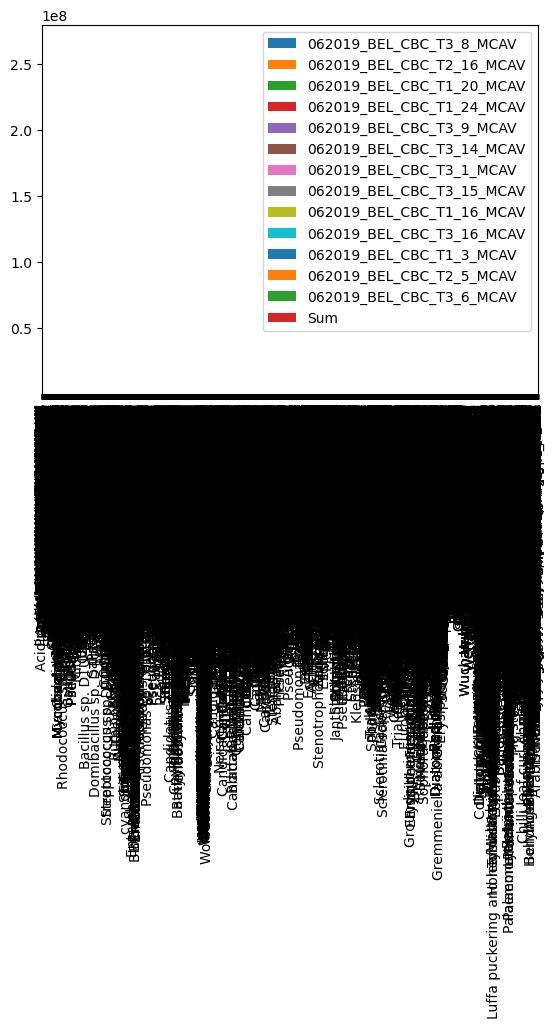

In [21]:
normalized_otu.plot.bar(stacked=True)

In [ ]:
# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=taxa, y=abundance, palette='pastel')
plt.xlabel('Taxa')
plt.ylabel('Abundance')
plt.title('Taxonomic Profile')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#### Old attempt with 16S

In [45]:
# Need to rename column names with sample IDs

#read file and seperate lines into a list of values
FILEPATH = '//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/SAMPLEID'
with open(FILEPATH, 'r') as file:
    sampleid = file.read().split()

# SAMPLEID contains list of sample ids 
print(sampleid)

['T1_12_2022', 'T1_13_2022', 'T1_16_2019', 'T1_20_2019', 'T1_24_2019', 'T1_40_2022', 'T1_57_2022', 'T1_70_2022', 'T2_10_2022', 'T2_16_2019', 'T3_13_2022', 'T3_14_2019', 'T3_15_2019', 'T3_19_2022', 'T3_1_2019', 'T3_40_2022', 'T3_48_2022', 'T3_49_2022', 'T3_51_2022', 'T3_8_2019', 'T3_9_2019']


In [46]:
# Create df with all the sample taxa info and abundances

import pandas as pd
import os

level='G'
otupath='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken'
#directory containing csv files
df = pd.DataFrame(columns=['sample_id', 'genus', 'otuid', 'abundance'])

# Iterate over sample_ids in the desired order
for sample in sampleid:
    filename = f"{sample}.csv"
    file_path = os.path.join(otupath, filename)
# Iterate over the CSV files in the directory
    if os.path.isfile(file_path):
        
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_csv(os.path.join(otupath, filename))
        
        # Extract relevant columns from the temporary DataFrame
        temp_df = temp_df[['name', 'taxonomy_id', 'new_est_reads']]
        
        # Rename columns to match the target DataFrame
        temp_df.columns = ['genus', 'otuid', 'abundance']
        
        # Add a new column for sample_id (assuming the filename is the sample_id)
        temp_df['sample_id'] = filename.split('.')[0]
        
        # Reorder columns to match the target DataFrame
        temp_df = temp_df[['sample_id', 'genus', 'otuid', 'abundance']]
        
        # Append the temporary DataFrame to the main DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)

# Display the resulting DataFrame
print(df)

        sample_id                      genus  otuid abundance
0      T1_12_2022                Dicyemennea  27378         3
1      T1_12_2022                Salpingoeca  14817        17
2      T1_12_2022                 Desmarella  14804         1
3      T1_12_2022                Stephanoeca  14798         3
4      T1_12_2022                   Polyoeca  14791         4
...           ...                        ...    ...       ...
13862   T3_9_2019                 Halomarina  24315         1
13863   T3_9_2019   Candidatus Nitrocosmicus  24404        41
13864   T3_9_2019                Cenarchaeum  24401         5
13865   T3_9_2019  Candidatus Nitrosopumilus  24399         2
13866   T3_9_2019                Pyrobaculum     49         1

[13867 rows x 4 columns]


In [47]:
# Checking if everything is the same size and in the same order for merging later
T3_9_2019=df['sample_id']=='T3_9_2019'
df[T3_9_2019].sort_values(by="genus")

,sample_id,genus,otuid,abundance
13511,T3_9_2019,Acanthamoeba,4081,119
13504,T3_9_2019,Acanthostaurus,9548,20
13671,T3_9_2019,Acetitomaculum,1989,1
13710,T3_9_2019,Acetobacterium,1929,3
13827,T3_9_2019,Acholeplasma,3923,5
...,...,...,...,...
13585,T3_9_2019,uncultured,26659,3
13590,T3_9_2019,uncultured,26637,4
13593,T3_9_2019,uncultured,26621,2
13598,T3_9_2019,uncultured,26674,1


In [48]:
# Checking if everything is the same size and in the same order for merging later
T1_12_2022=df['sample_id']=='T1_12_2022'
df[T1_12_2022].sort_values(by="genus")

# samples have different taxa - result of bracken i think

,sample_id,genus,otuid,abundance
271,T1_12_2022,1174-901-12,26040,1
482,T1_12_2022,ADurb.Bin120,25122,1
497,T1_12_2022,AKIW659,24432,2
493,T1_12_2022,AKYG587,2317,2
548,T1_12_2022,ANME-3,186,3
...,...,...,...,...
410,T1_12_2022,uncultured,14279,1
170,T1_12_2022,uncultured,9532,1
310,T1_12_2022,uncultured,25286,1
312,T1_12_2022,uncultured,25460,1


In [49]:
# Testing upload with kraken2reports 
path='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T1_12_2022.kreport2'
T1_12_2022 = pd.read_csv(path, sep='\t', header=None)
T1_12_2022

,0,1,2,3,4,5
0,99.77,20693709,20693709,U,0,unclassified
1,0.23,48519,650,R,1,root
2,0.16,32724,2060,D,4,Eukaryota
3,0.08,16951,51,D1,6428,Opisthokonta
4,0.06,12827,10,D,6430,Holozoa
...,...,...,...,...,...,...
13523,0.00,0,0,P,24228,Altiarchaeota
13524,0.00,0,0,C,24229,Altiarchaeia
13525,0.00,0,0,P,24367,Hadesarchaeaeota
13526,0.00,0,0,P,24368,Hydrothermarchaeota


In [50]:
path2='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T1_13_2022.kreport2'
T1_13_2022 = pd.read_csv(path2, sep='\t', header=None)
T1_13_2022

,0,1,2,3,4,5
0,99.76,20811345,20811345,U,0,unclassified
1,0.24,50615,1429,R,1,root
2,0.14,29818,1509,D,4,Eukaryota
3,0.09,19183,4,D1,6428,Opisthokonta
4,0.09,18873,1,D,6430,Holozoa
...,...,...,...,...,...,...
13523,0.00,1,1,G,24372,Candidatus Korarchaeum
13524,0.00,0,0,P,24228,Altiarchaeota
13525,0.00,0,0,C,24229,Altiarchaeia
13526,0.00,0,0,P,24368,Hydrothermarchaeota


In [ ]:
###### report outcomes:
0 - Percentage of fragments covered by the clade rooted at this taxon
1 - Number of fragments covered by the clade rooted at this taxon
2 - Number of fragments assigned directly to this taxon
3 - A rank code, indicating (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies. Taxa that are not at any of these 10 ranks have a rank code that is formed by using the rank code of the closest ancestor rank with a number indicating the distance from that rank. E.g., "G2" is a rank code indicating a taxon is between genus and species and the grandparent taxon is at the genus rank.
4 - NCBI taxonomic ID number
5 - Indented scientific name

In [68]:
ls 

LICENSE  README.md  kraken2otu.py


In [69]:
# trying to use new script to make otu table from kreport2 
#!git clone https://github.com/sipost1/kraken2OTUtable.git
SCRIPTPATH='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/bash_scripts/kraken2OTUtable'
INPUTFOLDER='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken'
EXTENSION='.kreport2'
LEVEL='G'

#!cp //project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/bash_scripts/kraken2OTUtable/kraken2otu kraken2otu

%run kraken2otu.py --inputfolder $INPUTFOLDER --level $LEVEL --extension $EXTENSION

#optional arguments:
#-h, --help            show this help message and exit
# --inputfolder INPUTFOLDER, -i INPUTFOLDER
#                    Input folder where report files can be found.
# --level LEVEL, -l LEVEL
#                      Taxonomic level to extract from kraken2 report.
#--extension EXTENSION, -e EXTENSION
#                      Extension of kraken2 report files. Default: .k2report

Reading /project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T3_1_2019.kreport2
Used indexes: field 4 for taxon rank, field 6 for taxon name.
Reading /project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T2_10_2022.kreport2
Used indexes: field 4 for taxon rank, field 6 for taxon name.
Reading /project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T3_48_2022.kreport2
Used indexes: field 4 for taxon rank, field 6 for taxon name.
Reading /project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T3_14_2019.kreport2
Used indexes: field 4 for taxon rank, field 6 for taxon name.
Reading /project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T3_40_2022.kreport2
Used indexes: field 4 for taxon rank, field 6 for taxon name.
Reading /project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/T2_16_2019.kreport2
Used indexes: field 4 for taxon rank, field 6 for taxon name.
Reading /project/pi_sarah_gignouxwolfsohn

In [70]:
path='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/otu_table_G.csv'
otu = pd.read_csv(path, header=0, index_col=0)
otu

,T3_1_2019,T2_10_20,T3_48_20,T3_14_2019,T3_40_20,T2_16_2019,T3_9_2019,T3_51_20,T1_12_20,T1_20_2019,...,T1_16_2019,T3_13_20,T3_8_2019,T3_19_20,T1_13_20,T1_24_2019,T3_15_2019,T1_70_20,T1_57_20,T3_49_20
otu,,,,,,,,,,,,,,,,,,,,,
Prosorhynchoides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fauvelopsis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hrabeiella,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rotaria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Limnognathia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nanoarchaeum,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
Candidatus Nanobsidianus,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Candidatus Nanopusillus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# make new taxa table 
genus=T1_13_2022[3]=='G'
genus_taxa=T1_13_2022[genus]
tax_table=genus_taxa.loc[:,(4,5)]

# export to csv
genus_path='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/genus_table.csv'
tax_table.to_csv(genus_path, index=False)

In [73]:
# Extract total read count from kraken slurm output (slurm-kraken-16155056.out)
# in order to normalize otu table 

import re
slurmdir='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/11_2023bash_scripts/slurm-kraken-16155056.out'

# Read the output report and extract the total number of reads
with open(slurmdir, 'r') as file:
    report_text = file.read()

# Extract total number of reads using regular expression
total_reads_pattern = re.compile(r'(\d+) sequences \(.* Mbp\) processed')
total_reads_matches = total_reads_pattern.findall(report_text)

# Create a dictionary to map sample ID to total reads
total_reads_dict = {sampleid[i]: int(total_reads_matches[i]) for i in range(len(sampleid))}

# Copy dict for troubleshooting
df_reads = df.copy()

# Add a new column 'total_reads' to the DataFrame
df_reads['total_reads'] = df_reads['sample_id'].map(total_reads_dict)

# Display the updated DataFrame
print(total_reads_matches)
print(df_reads)


['32901040', '23159221', '16020690', '17351886', '18763016', '24196261', '29615054', '43828341', '21196862', '23416543', '25723079', '10887256', '18950755', '25386963', '14265228', '30869362', '32953155', '18273682', '21259800', '10660464', '24769854', '31213609', '10636072', '34021149', '29595491', '25666947', '26606935', '30646029', '27629625', '35938893', '35413053', '16950294', '41309990']
        sample_id                      genus  otuid abundance  total_reads
0      T1_12_2022                Dicyemennea  27378         3     32901040
1      T1_12_2022                Salpingoeca  14817        17     32901040
2      T1_12_2022                 Desmarella  14804         1     32901040
3      T1_12_2022                Stephanoeca  14798         3     32901040
4      T1_12_2022                   Polyoeca  14791         4     32901040
...           ...                        ...    ...       ...          ...
13862   T3_9_2019                 Halomarina  24315         1     24769854
138

In [74]:
# Normalize: divide reads by total reads and multiply by 1mil
df_reads['abundance_normal'] = (df_reads['abundance'] / df_reads['total_reads'])*1E6
df_reads.head(5)


,sample_id,genus,otuid,abundance,total_reads,abundance_normal
0,T1_12_2022,Dicyemennea,27378,3,32901040,0.091183
1,T1_12_2022,Salpingoeca,14817,17,32901040,0.516701
2,T1_12_2022,Desmarella,14804,1,32901040,0.030394
3,T1_12_2022,Stephanoeca,14798,3,32901040,0.091183
4,T1_12_2022,Polyoeca,14791,4,32901040,0.121577


In [42]:
# Convert df to csv file to upload to R

# Specify the path where you want to save the CSV file
csv_path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/df_reads.csv'

# Save the DataFrame to a CSV file
df_reads.to_csv(csv_path, index=False)

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [105]:
# getting read totals for new otu table

import pandas as pd
import os

# Directory containing kreport2 files
otupath = '/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken'

# Dictionary to store total reads for each sample
total_reads_dict = {}

# Iterate over kreport2 files for each sample
for sample_id in sampleid:
    filename = f"{sample_id}.kreport2"
    file_path = os.path.join(otupath, filename)

    if os.path.isfile(file_path):
        # Load the data from the kreport2 file
        df = pd.read_csv(file_path, sep='\t', header=None)

        # Sum the second column for the current sample
        total_reads = df[1].sum()

        # Store the total reads in the dictionary
        total_reads_dict[sample_id] = total_reads

# Display the total number of reads for each sample ID
#for sample_id, total_reads in total_reads_dict.items():
#   print(f'Total Reads for {sample_id}: {total_reads}')
total_reads_dict

{'T1_12_2022': 21126849,
 'T1_13_2022': 21221384,
 'T1_16_2019': 26375641,
 'T1_20_2019': 8830557,
 'T1_24_2019': 17586886,
 'T1_40_2022': 16282309,
 'T1_57_2022': 33173332,
 'T1_70_2022': 16725967,
 'T2_10_2022': 17264803,
 'T2_16_2019': 35208119,
 'T3_13_2022': 13772410,
 'T3_14_2019': 22124260,
 'T3_15_2019': 20273276,
 'T3_19_2022': 9775246,
 'T3_1_2019': 30739776,
 'T3_40_2022': 27350877,
 'T3_48_2022': 14296473,
 'T3_49_2022': 16916025,
 'T3_51_2022': 14277777,
 'T3_8_2019': 17153561,
 'T3_9_2019': 14567874}

In [119]:
otu.shape
otu.columns

Index(['T3_48_20', 'T3_9_2019', 'T2_10_20', 'T3_14_2019', 'T1_12_20',
       'T1_20_2019', 'T3_51_20', 'T3_1_2019', 'T3_40_20', 'T2_16_2019',
       'T1_16_2019', 'T1_40_20', 'T3_13_20', 'T1_24_2019', 'T1_13_20',
       'T3_19_20', 'T1_70_20', 'T3_15_2019', 'T1_57_20', 'T3_49_20',
       'T3_8_2019'],
      dtype='object')

In [130]:
# column names got messed up in otu table, rename to match sampleids

# Your DataFrame column names
column_names = otu.columns

# Replace "20" with "2022" only for columns ending with "20"
updated_column_names = [name.replace("20", "2022") if name.endswith("20") else name for name in column_names]

# Create a new DataFrame with the updated column names
otu.columns=updated_column_names

# Display the resulting DataFrame
otu.head(5)

,T3_48_2022,T3_9_2019,T2_10_2022,T3_14_2019,T1_12_2022,T1_20_2019,T3_51_2022,T3_1_2019,T3_40_2022,T2_16_2019,...,T1_40_2022,T3_13_2022,T1_24_2019,T1_13_2022,T3_19_2022,T1_70_2022,T3_15_2019,T1_57_2022,T3_49_2022,T3_8_2019
otu,,,,,,,,,,,,,,,,,,,,,
Prosorhynchoides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fauvelopsis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hrabeiella,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rotaria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Limnognathia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
# Create a list of total reads in the desired order
total_reads_list = [total_reads_dict[col] for col in updated_column_names]
total_reads_list

# add to otu df
otu.loc['Total_Reads'] = total_reads

# Display the resulting OTU DataFrame with the new row
otu.tail()

,T3_48_2022,T3_9_2019,T2_10_2022,T3_14_2019,T1_12_2022,T1_20_2019,T3_51_2022,T3_1_2019,T3_40_2022,T2_16_2019,...,T1_40_2022,T3_13_2022,T1_24_2019,T1_13_2022,T3_19_2022,T1_70_2022,T3_15_2019,T1_57_2022,T3_49_2022,T3_8_2019
otu,,,,,,,,,,,,,,,,,,,,,
Candidatus Nanobsidianus,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Candidatus Nanopusillus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Candidatus Iainarchaeum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Candidatus Korarchaeum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Total_Reads,14567874,14567874,14567874,14567874,14567874,14567874,14567874,14567874,14567874,14567874,...,14567874,14567874,14567874,14567874,14567874,14567874,14567874,14567874,14567874,14567874


In [142]:
# Divide all abundances by sample's total read count and multiply by 1mil
total_reads = otu.loc['Total_Reads']

# Drop the "Total_Reads" row from the OTU DataFrame for normalization
otu_df = otu.drop('Total_Reads')

# Divide each column by the corresponding total read count
otu_normalized = otu_df.div(total_reads, axis=1)

# Multiply the normalized values by 1,000,000
otu_normalized *= 1000000

# Display the resulting normalized OTU DataFrame
print(otu_normalized)

                          T3_48_2022  T3_9_2019  T2_10_2022  T3_14_2019  \
otu                                                                       
Prosorhynchoides                 0.0        0.0    0.000000         0.0   
Fauvelopsis                      0.0        0.0    0.000000         0.0   
Hrabeiella                       0.0        0.0    0.000000         0.0   
Rotaria                          0.0        0.0    0.000000         0.0   
Limnognathia                     0.0        0.0    0.000000         0.0   
...                              ...        ...         ...         ...   
Nanoarchaeum                     0.0        0.0    0.000000         0.0   
Candidatus Nanobsidianus         0.0        0.0    0.068644         0.0   
Candidatus Nanopusillus          0.0        0.0    0.000000         0.0   
Candidatus Iainarchaeum          0.0        0.0    0.000000         0.0   
Candidatus Korarchaeum           0.0        0.0    0.000000         0.0   

                        

In [158]:
otu_normalized['sum']=otu_normalized.sum(axis=1)
otu_sorted=otu_normalized.sort_values(by='sum', ascending=False)
otu_sort=otu_sorted.drop('sum',axis=1)

otu_path='/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/otu_sort.csv'
otu_sort.to_csv(otu_path, index=True)

In [157]:
otu_sort.head(5)

,T3_48_2022,T3_9_2019,T2_10_2022,T3_14_2019,T1_12_2022,T1_20_2019,T3_51_2022,T3_1_2019,T3_40_2022,T2_16_2019,...,T1_40_2022,T3_13_2022,T1_24_2019,T1_13_2022,T3_19_2022,T1_70_2022,T3_15_2019,T1_57_2022,T3_49_2022,T3_8_2019
otu,,,,,,,,,,,,,,,,,,,,,
Populus,316.587033,341.642164,181.769831,716.233542,579.425660,235.655525,313.978553,765.314143,553.546798,1371.442394,...,379.465116,192.341038,416.121117,23.201738,299.288695,523.892505,741.357318,430.261821,516.067066,499.180594
Blastomyces,296.062418,395.184637,63.907747,260.504724,220.416514,44.550083,227.967375,301.553954,97.543403,167.079973,...,268.261518,299.837849,186.231704,4.805094,192.684259,399.097356,85.118803,1013.737488,420.857566,149.987569
Pseudomonas,118.685815,123.696841,168.452857,142.093486,157.126565,51.345859,83.471342,228.928394,127.060407,396.488877,...,140.720602,110.791733,116.351912,70.634878,104.956976,149.232482,175.111344,200.646985,111.615463,106.947658
Citrus,305.535317,78.048451,21.897499,97.406114,10.571206,35.420405,52.993319,65.623851,77.293365,101.250189,...,220.004649,26.084795,50.728061,16.955116,213.071585,212.522431,17.161049,216.778371,295.307332,151.635029
Blastocystis,119.303613,152.596048,30.821244,88.962878,71.389964,23.270382,86.423043,158.774026,58.347567,73.106069,...,116.695133,89.031522,80.725575,1.166951,68.232331,141.887553,34.184810,399.440577,116.351912,86.148466


##### KrakenTools 
- downstream analysis using kraken results
- https://ccb.jhu.edu/software/krakentools/index.shtml
- download zip file 

In [ ]:
SCRIPTPATH=/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/bash_scripts/KrakenTools-master/DiversityTools
cd $SCRIPTPATH
# make scripts executable 
chmod +x alpha\_diversity.py
./alpha\_diversity.py -h
# input file must be bracken

chmod +x beta\_diversity.py
./beta\_diversity.py -h
# Bray-Curtis dissimilarity

In [ ]:
# Alpha Diversity
# Shannon diversity - genus level 

SCRIPTPATH=/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/bash_scripts/KrakenTools-master/DiversityTools
FILEPATH=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav_taxonomy/kraken
#ls $FILEPATH | find *.kreport2 > kraken_list.txt
cat kraken_list.txt| sed 's/.kreport2/''/' > SAMPLEID

#this is bash script to be used in terminal..couldn't get bracken scripts to work in nb
while IFS= read -r line; do
    python $SCRIPTPATH/alpha_diversity.py -f ${line}.bracken 
done < SAMPLEID

# don't know if it does multiple at a time or just one at a time...and what is output?
#-f, --filename MYFILE.BRACKEN..........Bracken output file
#-a, --alpha TYPE.......................Single letter alpha diversity type (Sh, BP, Si, ISi, F)

Shannon's diversity: 2.8405589418696024
Shannon's diversity: 3.747956479976194
Shannon's diversity: 3.240773802595393
Shannon's diversity: 3.357943870893113
Shannon's diversity: 3.127505271223385
Shannon's diversity: 2.948836172095586
Shannon's diversity: 3.155355846512862
Shannon's diversity: 2.9534230075080843
Shannon's diversity: 3.837848266676804
Shannon's diversity: 3.017049434243576
Shannon's diversity: 3.3014806325360837
Shannon's diversity: 3.1828393709134533
Shannon's diversity: 2.673104478260622
Shannon's diversity: 2.8628687828400676
Shannon's diversity: 3.1197450036741374
Shannon's diversity: 3.4793331275395554
Shannon's diversity: 2.842877602269089
Shannon's diversity: 2.9019378226014787
Shannon's diversity: 3.1864428196047045
Shannon's diversity: 3.1428692882448113
Shannon's diversity: 3.0649759367640863

In [ ]:
cat SAMPLEID

T1_12_2022
T1_13_2022
T1_16_2019
T1_20_2019
T1_24_2019
T1_40_2022
T1_57_2022
T1_70_2022
T2_10_2022
T2_16_2019
T3_13_2022
T3_14_2019
T3_15_2019
T3_19_2022
T3_1_2019
T3_40_2022
T3_48_2022
T3_49_2022
T3_51_2022
T3_8_2019
T3_9_2019

In [ ]:
# Beta Diversity

# collect list of input files
FILEPATH=//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav_taxonomy/kraken
mv *_species.bracken species
ls $FILEPATH | find *.bracken > bracken_list.txt
FILES=xargs -a bracken_list.txt -d '\n'

In [ ]:
python $SCRIPTPATH/beta_diversity.py --type bracken --input-files T1_12_2022.bracken T1_13_2022.bracken T1_16_2019.bracken T1_20_2019.bracken T1_24_2019.bracken T1_40_2022.bracken T1_57_2022.bracken T1_70_2022.bracken T2_10_2022.bracken T2_16_2019.bracken T3_13_2022.bracken T3_14_2019.bracken T3_15_2019.bracken T3_19_2022.bracken T3_1_2019.bracken T3_40_2022.bracken T3_48_2022.bracken T3_49_2022.bracken T3_51_2022.bracken T3_8_2019.bracken T3_9_2019.bracken > b_diversity.txt


#### Skbio 
- to create pcoa plot from b diversity matrix

In [ ]:
from skbio.diversity import beta_diversity
from skbio.stats.distance import mantel

In [ ]:
#view b diversity file 
file_path = '//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/b_diversity.txt'

with open(file_path, 'r') as file:
    content = file.read()
    print(content)

In [ ]:
# Plan
# load in first part as a seperate file so i can keep track of which sample goes with which
import os
os.getcwd()
# load in second part as compatible distance matrix 

In [ ]:
import pandas as pd
import numpy as np

# Read the first 20 lines separately
with open(file_path, 'r') as file:
    first_20_lines = [file.readline().strip() for _ in range(21)]

# Define a function to convert "x.xxx" to float, replacing with NaN
def convert_xxxx_to_float(s):
    if s == 'x.xxx':
        return 0.0
    try:
        return float(s)
    except (ValueError, TypeError):
        return 0.0

# Specify the data type and the converter for the columns
dtype = float
converters = {i: convert_xxxx_to_float for i in range(1, 22)}  # Assuming you want to apply the converter to columns 1 to 21

# Skip the first 21 + 1 lines (header lines + "x" line)
skip_rows = 21

# Load the data using numpy
bd = np.genfromtxt(file_path, delimiter='\t', skip_header=skip_rows, dtype=dtype, converters=converters)

# Print the modified data array
print(bd)
bd.shape

In [ ]:
#transpose bd and add it to itself to make symmetrical (use transposed values to replace 0s)
bd3 = bd + bd.T
bd3.shape

In [ ]:
#convert to dataframe mainly to view better
bd_df=pd.DataFrame(bd3)

#column and row headings were doubled because of the vectorized addition, so dropping those first columns and rows 
df=bd_df.drop(columns=[0])
df2=df.drop([0])
df2

In [ ]:
# Need to rename column names with sample IDs

#read file and seperate lines into a list of values
FILEPATH = '//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/mcav/taxonomy/kraken/SAMPLEID'
with open(FILEPATH, 'r') as file:
    sampleid = file.read().split()

# SAMPLEID contains list of sample ids 
print(sampleid)


In [ ]:
# Rename columns using the 'sampleid' list
df2.columns = sampleid
print(df2)

In [ ]:
from skbio import DistanceMatrix
# Convert dataframe to numpy array
bdist = df2.to_numpy()

# Create a DistanceMatrix object and keep column names as headings in matrix 
distance_matrix = DistanceMatrix(bdist, ids=df2.columns)
print(distance_matrix)

In [ ]:
# load in CBC_Samples metadata 
metapath= '//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata/CBC_samples.csv'
meta=pd.read_csv(metapath, index_col='Tubelabel_species')
meta

In [ ]:
# Load in CBC Metagenomics metadata too 
meta2path = '//project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata/Metagenomics_Tracker_Belize.csv'
meta2=pd.read_csv(meta2path, index_col='Seq_file')
meta2

In [ ]:
from skbio.stats.ordination import pcoa

pcoa_results = pcoa(distance_matrix)

In [ ]:
meta2.columns

In [ ]:
# Check for duplicate index labels
duplicate_labels = meta2.index[meta2.index.duplicated()]
print("Duplicate labels:", duplicate_labels)


In [ ]:
# Remove duplicate index labels
meta_mcav = meta2[~meta2.index.duplicated()]

In [ ]:
meta_mcav['Health_Status ']

In [ ]:
meta_mcav['Health_Status ']
# Remove "_MCAV" in sampleid in meta df
meta_mcav.index = meta_mcav.index.str.replace('_MCAV', '')

# Display the modified DataFrame
meta_mcav['Health_Status ']


In [ ]:
# Assuming `pcoa_results` contains your ordination results
ids_in_ordination = set(pcoa_results.samples.index)
ids_in_dataframe = set(meta_mcav.index)  

# Check for any IDs in the ordination results that are not in the data frame
missing_ids = ids_in_ordination - ids_in_dataframe

if missing_ids:
    print(f"Warning: IDs {missing_ids} are present in the ordination results but not in the data frame.")

# Continue with plotting code
fig = pcoa_results.plot(df=meta_mcav,
                        column='Health_Status ',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by health status',
                        cmap='Reds',
                        s=35)
# was getting error that sampleids didnt match df and pcoa results...

In [ ]:
# check sample ids in meta df
meta_mcav.index

In [ ]:
# Strip spaces from indices in meta_mcav
meta_mcav.index = meta_mcav.index.str.strip()
# Check one more time
meta_mcav.index

In [ ]:
#plot pcoa results by health status 
%matplotlib inline

fig = pcoa_results.plot(df=meta_mcav,
                        column='Health_Status ',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by health status',
                        cmap='Reds',
                        s=35)

In [ ]:
%matplotlib inline

fig = pcoa_results.plot(df=meta_mcav,
                        column='Health_Status ',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by health status',
                        cmap='Reds',
                        s=35)

In [ ]:
meta_mcav

In [ ]:
meta